<a href="https://colab.research.google.com/github/cshgiser/HRSM/blob/main/HRSM_MAPPING_pipeline_ML_paraTune_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial settings (authorize, connect GD, install packages, etc)

In [ ]:
# @title get GEE authorization
import ee

# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='ee-scai62')

In [ ]:
# @title Connect to my Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r '/content/gdrive/My Drive/NIFA_Download/StartFolder/' .

In [ ]:
!cp '/content/gdrive/My Drive/NIFA_Download/StartFolder/ML_sites/Sentinel2_arr.npy' /content/
!cp '/content/gdrive/My Drive/NIFA_Download/StartFolder/ML_sites/era5hour_arr.npy' /content/
!cp '/content/gdrive/My Drive/NIFA_Download/StartFolder/ML_sites/sentinel1_arr.npy' /content/
!cp '/content/gdrive/My Drive/NIFA_Download/StartFolder/ML_sites/HLSL30_arr.npy' /content/

In [ ]:
# @title Install necessary packages
!pip install folium
!pip install geopandas
!pip install netCDF4
!pip install --upgrade xee
!pip install rasterio
!pip install ipywidgets
!pip install permetrics==2.0.0
!pip install mapie
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 123.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.1/187.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 133.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 

In [ ]:
# @title Import packages
from mapie.regression import SplitConformalRegressor, ConformalizedQuantileRegressor
import lightgbm as lgb

import folium
from folium import Figure
import geopandas as gpd
import json
import geemap
import numpy as np
from shapely.geometry import mapping
import pandas as pd
import netCDF4 as nc
import xarray
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
import math
import time
import os
from datetime import datetime, timedelta
import joblib
import ipywidgets as widgets
from IPython.display import display
from permetrics import RegressionMetric
import osgeo.gdal as gdal
from osgeo import osr, gdalconst
from scipy.stats import rankdata

## read sites information and visualize

In [ ]:
# @title read csv file: points id with coordinates
df_sites = pd.read_csv('/content/StartFolder/ML_sites/ISMN_PSA_merged_sites_with_features.csv')
df_sites = df_sites[['ID', 'Longitude', 'Latitude']]
df_sites

,ID,Longitude,Latitude
0,0,-98.096900,37.213400
1,4,-97.488000,36.607000
2,9,-97.082000,36.926000
3,10,-98.173000,35.880000
4,15,-95.788000,37.068000
...,...,...,...
460,2307,-91.226189,39.338249
461,2308,-93.913678,40.282836
462,2309,-88.538605,42.761824
463,2310,-79.229836,34.775208


In [ ]:
# @title define feature collections
lons_sub = ee.List(df_sites['Longitude'].tolist())
lats_sub = ee.List(df_sites['Latitude'].tolist())
idnum_sub = ee.List(df_sites['ID'].tolist())
points = lons_sub.zip(lats_sub).zip(idnum_sub).map(lambda coords: ee.Feature(ee.Geometry.Point(ee.List(coords).get(0)),{'id_num': ee.List(coords).get(1)}))
feature_collection = ee.FeatureCollection(points)

In [ ]:
# @title visualization - spatial distribution of sites
import folium
from folium import Figure

fig = Figure(width=800, height=600)
m = folium.Map(location=[42, -95.25], zoom_start=4)


roi_geojson = feature_collection.getInfo()
folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google Satellite',
    name='Satellite',
    overlay=True
).add_to(m)
folium.GeoJson(roi_geojson).add_to(m)

fig.add_child(m)

## Read ee.images (constant images)

In [ ]:
#@title read images to array

# Landcover
LC = ee.ImageCollection('USGS/NLCD_RELEASES/2019_REL/NLCD').filterDate('2016-01-01', '2022-12-31').select('landcover').first()
lc_proj = LC.projection()

#polaris
bd_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_0_5').first().rename('bd_0_5')
bd_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_5_15').first().rename('bd_5_15')
bd_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_15_30').first().rename('bd_15_30')
bd_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_30_60').first().rename('bd_30_60')
bd_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_60_100').first().rename('bd_60_100')
bd_0_100 = bd_0_5.multiply(0.05).add(bd_5_15.multiply(0.1)).add(bd_15_30.multiply(0.15)).add(bd_30_60.multiply(0.3)).add(bd_60_100.multiply(0.4)).rename('bd_0_100')

clay_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_0_5').first().rename('clay_0_5')
clay_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_5_15').first().rename('clay_5_15')
clay_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_15_30').first().rename('clay_15_30')
clay_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_30_60').first().rename('clay_30_60')
clay_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_60_100').first().rename('clay_60_100')
clay_0_100 = clay_0_5.multiply(0.05).add(clay_5_15.multiply(0.1)).add(clay_15_30.multiply(0.15)).add(clay_30_60.multiply(0.3)).add(clay_60_100.multiply(0.4)).rename('clay_0_100')

ksat_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_0_5').first().rename('ksat_0_5')
ksat_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_5_15').first().rename('ksat_5_15')
ksat_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_15_30').first().rename('ksat_15_30')
ksat_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_30_60').first().rename('ksat_30_60')
ksat_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_60_100').first().rename('ksat_60_100')


sand_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_0_5').first().rename('sand_0_5')
sand_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_5_15').first().rename('sand_5_15')
sand_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_15_30').first().rename('sand_15_30')
sand_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_30_60').first().rename('sand_30_60')
sand_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_60_100').first().rename('sand_60_100')
sand_0_100 = sand_0_5.multiply(0.05).add(sand_5_15.multiply(0.1)).add(sand_15_30.multiply(0.15)).add(sand_30_60.multiply(0.3)).add(sand_60_100.multiply(0.4)).rename('sand_0_100')

silt_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_0_5').first().rename('silt_0_5')
silt_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_5_15').first().rename('silt_5_15')
silt_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_15_30').first().rename('silt_15_30')
silt_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_30_60').first().rename('silt_30_60')
silt_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_60_100').first().rename('silt_60_100')
silt_0_100 = silt_0_5.multiply(0.05).add(silt_5_15.multiply(0.1)).add(silt_15_30.multiply(0.15)).add(silt_30_60.multiply(0.3)).add(silt_60_100.multiply(0.4)).rename('silt_0_100')

polaris = bd_0_5.addBands(bd_0_100)\
          .addBands(ksat_0_5).addBands(ksat_0_5)\
          .addBands(clay_0_5).addBands(clay_0_100)\
          .addBands(sand_0_5).addBands(sand_0_100)\
          .addBands(silt_0_5).addBands(silt_0_100)

polaris_ksat = ksat_0_5.addBands(ksat_5_15).addBands(ksat_15_30).addBands(ksat_30_60).addBands(ksat_60_100)


dem_image = ee.Image('projects/ee-scai62/assets/COUNS_dem100m')
TWII_image = ee.Image('projects/ee-scai62/assets/CONUS_dem100m_TWII')
aspect_image = ee.Image('projects/ee-scai62/assets/CONUS_dem100m_aspect')
slopeDegree_image = ee.Image('projects/ee-scai62/assets/CONUS_dem100m_slopeDegree')

dem_image = dem_image.reproject(lc_proj)
TWII_image = TWII_image.reproject(lc_proj)
aspect_image = aspect_image.reproject(lc_proj)
slopeDegree_image = slopeDegree_image.reproject(lc_proj)

dem_image = dem_image.reproject(crs='EPSG:4326', scale=100)
TWII_image = TWII_image.reproject(crs='EPSG:4326', scale=100)
aspect_image = aspect_image.reproject(crs='EPSG:4326', scale=100)
slopeDegree_image = slopeDegree_image.reproject(crs='EPSG:4326', scale=100)

In [ ]:
# @title extract values from constant images

dem_values = dem_image.sampleRegions(collection=feature_collection,scale=100)
elevation_arr = np.array(dem_values.aggregate_array('b1').getInfo())[:]
dem_idnum_arr = np.array(dem_values.aggregate_array('id_num').getInfo())[:]
TWII_values = TWII_image.sampleRegions(collection=feature_collection,scale=100)
TWII_arr = np.array(TWII_values.aggregate_array('b1').getInfo())[:]
aspect_values = aspect_image.sampleRegions(collection=feature_collection,scale=100)
aspect_arr = np.array(aspect_values.aggregate_array('b1').getInfo())[:]
slopeDegree_values = slopeDegree_image.sampleRegions(collection=feature_collection,scale=100)
slopeDegree_arr = np.array(slopeDegree_values.aggregate_array('b1').getInfo())[:]


# extract pixel values of LC using feature collection
LC_values = LC.sampleRegions(collection=feature_collection,scale=100)
landcover_arr = np.array(LC_values.aggregate_array('landcover').getInfo())[:]
LC_idnum_arr = np.array(LC_values.aggregate_array('id_num').getInfo())[:]

# extract pixel values of Polaris soil using feature collection
polaris_values = polaris.sampleRegions(collection=feature_collection,scale=100)
ml_sand_0_5 = np.array(polaris_values.aggregate_array('sand_0_5').getInfo())[:]
ml_sand_0_100 = np.array(polaris_values.aggregate_array('sand_0_100').getInfo())[:]
ml_clay_0_5 = np.array(polaris_values.aggregate_array('clay_0_5').getInfo())[:]
ml_clay_0_100 = np.array(polaris_values.aggregate_array('clay_0_100').getInfo())[:]
ml_bd_0_5 = np.array(polaris_values.aggregate_array('bd_0_5').getInfo())[:]
ml_bd_0_100 = np.array(polaris_values.aggregate_array('bd_0_100').getInfo())[:]
ml_ksat_0_5 = np.array(polaris_values.aggregate_array('ksat_0_5').getInfo())[:]
polaris_idnum_arr = np.array(polaris_values.aggregate_array('id_num').getInfo())[:]


# extract pixel values of Polaris soil using feature collection
polaris_ksat_values = polaris_ksat.sampleRegions(collection=feature_collection,scale=100)
#ksat
ksat_0_5_arr = np.array(polaris_ksat_values.aggregate_array('ksat_0_5').getInfo())[:]
ksat_5_15_arr = np.array(polaris_ksat_values.aggregate_array('ksat_5_15').getInfo())[:]
ksat_15_30_arr = np.array(polaris_ksat_values.aggregate_array('ksat_15_30').getInfo())[:]
ksat_30_60_arr = np.array(polaris_ksat_values.aggregate_array('ksat_30_60').getInfo())[:]
ksat_60_100_arr = np.array(polaris_ksat_values.aggregate_array('ksat_60_100').getInfo())[:]


In [ ]:
#@title processing constant values
elevation_arr[elevation_arr<-1000] = np.nan

sinAsp_arr = np.sin(aspect_arr/180*np.pi)
sinAsp_arr[aspect_arr==-1] = 0
cosAsp_arr = np.cos(aspect_arr/180*np.pi)
cosAsp_arr[aspect_arr == -1] = 0

ml_ksat_0_5 = np.power(10, ml_ksat_0_5)  # convert to cm/hr
ksat_0_5_arr = np.power(10, ksat_0_5_arr)
ksat_5_15_arr = np.power(10, ksat_5_15_arr)
ksat_15_30_arr = np.power(10, ksat_15_30_arr)
ksat_30_60_arr = np.power(10, ksat_30_60_arr)
ksat_60_100_arr = np.power(10, ksat_60_100_arr)

d0_5 = 0.05
d5_15 = 0.10
d15_30 = 0.15
d30_60 = 0.30
d60_100 = 0.40
d_total = d0_5 + d5_15 + d15_30 + d30_60 + d60_100
ml_ksat_0_100 = d_total/(d0_5/ksat_0_5_arr +
                                d5_15/ksat_5_15_arr +
                                d15_30/ksat_15_30_arr +
                                d30_60/ksat_30_60_arr +
                                d60_100/ksat_60_100_arr)


In [ ]:
print("max ksat at surface: ", ml_ksat_0_5.max())
print("min ksat at surface: ", ml_ksat_0_5.min())
print("max ksat at rootzone: ", ml_ksat_0_100.max())
print("min ksat at rootzone: ", ml_ksat_0_100.min())
print("max slope", slopeDegree_arr.max())
print("min slope", slopeDegree_arr.min())

max ksat at surface:  30.138726934051125
min ksat at surface:  0.07076755705530448
max ksat at rootzone:  21.737776898313808
min ksat at rootzone:  0.060529058583479255
max slope 10.727317810058594
min slope 0.0


In [ ]:
#@title reorganize dataframe

df_constant = pd.DataFrame({
    'ID': dem_idnum_arr,
    'elevation': elevation_arr,
    'sinAspect': sinAsp_arr,
    'cosAspect': cosAsp_arr,
    'slope': slopeDegree_arr,
    'landcover': landcover_arr,
    'sand_0_5[0-100]': ml_sand_0_5,
    'sand_0_100[0-100]': ml_sand_0_100,
    'clay_0_5[0-100]': ml_clay_0_5,
    'clay_0_100[0-100]': ml_clay_0_100,
    'ksat_0_5[cm/hr]': ml_ksat_0_5,
    'ksat_0_100[cm/hr]': ml_ksat_0_100,
    'bd_0_5[g/cm3]': ml_bd_0_5,
    'bd_0_100[g/cm3]': ml_bd_0_100})

merged_df = df_constant.merge(df_sites, on='ID')


refer_id_arr = merged_df['ID'].to_numpy()
refer_lon_arr = merged_df['Longitude'].to_numpy()
refer_lat_arr = merged_df['Latitude'].to_numpy()

refer_id_idx_dict = {}
for i in range(len(refer_id_arr)):
    refer_id_idx_dict[refer_id_arr[i]] = i


len(refer_id_arr)


465

In [ ]:
merged_df

,ID,elevation,sinAspect,cosAspect,slope,landcover,sand_0_5[0-100],sand_0_100[0-100],clay_0_5[0-100],clay_0_100[0-100],ksat_0_5[cm/hr],ksat_0_100[cm/hr],bd_0_5[g/cm3],bd_0_100[g/cm3],Longitude,Latitude
0,0,417.555634,0.913626,-0.406556,0.349190,82,52.193310,53.912126,12.909578,14.483881,5.351180,5.953604,1.378977,1.478685,-98.096900,37.213400
1,4,313.704437,0.191835,0.981427,0.338207,82,18.835024,11.712947,18.764620,37.546910,1.208138,0.109851,1.395879,1.419970,-97.488000,36.607000
2,9,350.284882,0.701168,-0.712996,0.356581,82,19.090847,11.166364,19.364309,35.871157,1.566082,0.200810,1.302707,1.397303,-97.082000,36.926000
3,10,363.112183,0.783549,-0.621330,0.816110,82,18.471973,13.331047,18.593222,31.508224,1.528644,0.535007,1.392853,1.421840,-98.173000,35.880000
4,15,251.568390,0.317945,0.948109,0.532896,81,7.719512,5.865540,22.227104,41.835092,0.844509,0.089935,1.309091,1.354571,-95.788000,37.068000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2307,261.522186,-0.407143,-0.913365,0.789269,82,5.217246,4.005519,18.870399,36.755791,1.535135,0.460775,1.308975,1.322520,-91.226189,39.338249
461,2308,307.054657,0.940988,-0.338440,0.870854,82,4.049239,2.873906,26.458738,37.230244,1.030728,0.315268,1.295596,1.360127,-93.913678,40.282836
462,2309,283.783295,0.998397,-0.056594,0.864215,82,26.422821,35.205990,14.195803,20.271144,2.713178,3.763616,1.405403,1.481477,-88.538605,42.761824
463,2310,61.951084,0.329500,-0.944156,0.093066,82,73.097984,60.616123,8.408833,20.567690,4.695941,1.279224,1.600922,1.572607,-79.229836,34.775208


## define study area and period

In [ ]:
# prompt: get the boundary of feature_collection

roi = feature_collection.geometry().bounds()


start_date = '2016-01-01'
end_date = '2025-01-01'

## read observations

In [ ]:
ISMN_sm_surface_arr = np.load('/content/StartFolder/ML_sites/ISMN_sm_surface_arr.npy')  # 153*78912
ISMN_sm_root_arr = np.load('/content/StartFolder/ML_sites/ISMN_sm_root_arr.npy')  #
ISMN_id_arr = np.load('/content/StartFolder/ML_sites/ISMN_id_arr.npy')

PSA_sm_surface_arr = np.load('/content/StartFolder/ML_sites/PSA_sm_surface_arr.npy')  # 312*78912
PSA_sm_root_arr = np.load('/content/StartFolder/ML_sites/PSA_sm_root_arr.npy')
PSA_id_arr = np.load('/content/StartFolder/ML_sites/PSA_id_arr.npy')

referIDArr = np.concatenate([ISMN_id_arr, PSA_id_arr])
obs_sm_surface_arr = np.concatenate([ISMN_sm_surface_arr, PSA_sm_surface_arr], axis=0)
obs_sm_root_arr = np.concatenate([ISMN_sm_root_arr, PSA_sm_root_arr], axis=0)
ISMN_sm_surface_arr = None
ISMN_sm_root_arr = None
PSA_sm_surface_arr = None
PSA_sm_root_arr = None

In [ ]:
print(obs_sm_surface_arr.shape)
print(obs_sm_root_arr.shape)

(465, 78912)
(465, 78912)


In [ ]:
referIDArr - dem_idnum_arr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Get ee imagecollections

In [ ]:
# @title Era5-land
start_date_era5 = (datetime.strptime(start_date, '%Y-%m-%d')- timedelta(hours=120+24)).strftime('%Y-%m-%d')

era5hour_short = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")\
                    .filterBounds(roi).filterDate(start_date_era5, end_date)\
                    .map(lambda img: img.addBands(
                        img.select('u_component_of_wind_10m').hypot(img.select('v_component_of_wind_10m')).rename('wind_10m')
                        )).select([
                            'temperature_2m',    # 2m air temperature, K
                            'dewpoint_temperature_2m',  # 2m dew point temperature, K
                            'wind_10m',  # wind speed, m/s
                            'surface_pressure',  # atmospheric surface pressure, Pa
                            ])


era5hour_mid = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").filterBounds(roi).filterDate(start_date_era5, end_date).select([
    'surface_solar_radiation_downwards_hourly',  # solar radiation, J
    'surface_thermal_radiation_downwards_hourly',  # thermal radiation, J
    ])


era5hour_long = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").filterBounds(roi).filterDate(start_date_era5, end_date).select([
    'total_evaporation_hourly',  # total evaporation, m
    'total_precipitation_hourly',   # precipitation, m
    ])



In [ ]:
# @title HLSL30

###note: no scale factor for HLSL30 product.

def bitwiseExtract(img, fromBit, toBit):
  maskSize = ee.Number(1).add(toBit).subtract(fromBit)
  mask = ee.Number(1).leftShift(maskSize).subtract(1)
  return img.rightShift(fromBit).bitwiseAnd(mask)

# remove low quality data
def maskHLSL30(image):
  qcDay = image.select('Fmask')
  cloud = bitwiseExtract(qcDay, 1, 1).eq(0)
  cloudshadow = bitwiseExtract(qcDay, 3, 3).eq(0)
  snowice = bitwiseExtract(qcDay, 4, 4).eq(0)
  water = bitwiseExtract(qcDay, 5, 5).eq(0)
  aerosol = bitwiseExtract(qcDay, 6, 7).lte(2)
  mask = cloud.And(cloudshadow).And(snowice).And(water).And(aerosol)

  return    image.updateMask(mask).copyProperties(image, ['system:time_start'])


HLSL30 = ee.ImageCollection("NASA/HLS/HLSL30/v002").filterBounds(roi)\
    .filterDate(start_date, end_date).map(maskHLSL30) \
		.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'B10', 'B11'])


In [ ]:
# @title Sentinel-2
# Sentinel-2 images

# old version
# def maskSentinel2(img):
#   cloudOpaqueBitMask = (1 << 10);
#   cloudCirrusMask = (1 << 11);
#   # Get the pixel QA band.
#   qa = img.select('QA60')
#   # Both flags should be set to zero, indicating clear conditions.
#   mask = qa.bitwiseAnd(cloudOpaqueBitMask).eq(0) \
#                 .And(qa.bitwiseAnd(cloudCirrusMask).eq(0))
#   return img.updateMask(mask).copyProperties(img, ['system:time_start'])                  #.multiply(0.0001).toFloat().copyProperties(img, ['mydate'])  # after applying updateMask(). all properties will be lost


def maskSentinel2(img):
  # Get the pixel QA band.
  scl = img.select('SCL')
  mask = scl.neq(8).And(scl.neq(9)).And(scl.neq(10)).And(scl.neq(11))
  return img.updateMask(mask).copyProperties(img, ['system:time_start'])

# def add_date(img):
#   date_start = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd-HH')
#   return img.set('mydate', date_start)


Sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
            .filterDate(start_date, end_date).filterBounds(roi)\
            .map(maskSentinel2)\
            .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'])


In [ ]:
# @title Sentinel-1

def preprocess_vv(image):
    vv_masked = image.updateMask(image.gt(-20).And(image.lt(-5)))
    vv_filtered = vv_masked.convolve(ee.Kernel.gaussian(3))
    return vv_filtered #.rename('VV').copyProperties(image, ['system:time_start'])

# Define preprocessing for VH
def preprocess_vh(image):
    vh_masked = image.updateMask(image.gt(-30).And(image.lt(-10)))
    vh_filtered = vh_masked.convolve(ee.Kernel.gaussian(3))
    return vh_filtered #.rename('VH').copyProperties(image, ['system:time_start'])


def merge_bands(image):
    vv = image.select('VV')
    vh = image.select('VH')
    angle = image.select('angle')

    vv_prep = preprocess_vv(vv)      # Apply mask + smoothing to VV
    vh_prep = preprocess_vh(vh)      # Apply mask + smoothing to VH

    merged = vv_prep.addBands(vh_prep).addBands(angle.rename('angle'))

    return merged.copyProperties(image, ['system:time_start'])

def to_float(image):
    all_bands = image.bandNames()
    return image.select(all_bands).float().copyProperties(image, ['system:time_start'])

Sentinel1 = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterDate(start_date, end_date)
    .filterBounds(roi)
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
    # .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
    .sort('SLC_Processing_start')
    .map(merge_bands).map(to_float)
)



## ML models - prepare Xy

In [ ]:
# @title Define weights for ERA5 data
def make_weights(n):
    weights = 1.0 / np.arange(n, 0, -1)      # reversed sequence [n ... 1]
    weights = weights / weights.sum()        # normalize
    return weights, ee.List(weights.tolist())

# Short-term (24h)
short_term_weights, ee_short_term_weights = make_weights(24)
# print("Short-term weights:", short_term_weights)

# Mid-term (72h)
mid_term_weights, ee_mid_term_weights = make_weights(72)
# print("Mid-term weights:", mid_term_weights)

# Long-term (120h)
long_term_weights, ee_long_term_weights = make_weights(120)
# print("Long-term weights:", long_term_weights)


In [ ]:
#@title Create year, doy, hour list: doy is an input for ML models, year, doy and hour provide time info for results
start_datetime = datetime(2016, 1, 1, 0, 0, 0)
datetime_list = [start_datetime + timedelta(hours=i) for i in range(78912)]
doy_list = np.array([dt.timetuple().tm_yday for dt in datetime_list])
year_list = np.array([dt.year for dt in datetime_list])
hour_list = np.array([dt.hour for dt in datetime_list])
print(len(doy_list))

78912


In [ ]:
start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
end_datetime = datetime.strptime(end_date, '%Y-%m-%d')  # end_date

num_hours = int((end_datetime - start_datetime).total_seconds()/3600)
print(num_hours)

era5hour_arr = np.zeros((8, num_hours, len(refer_id_arr)))
sentinel1_arr = np.zeros((3, num_hours, len(refer_id_arr)))
HLSL30_arr = np.zeros((9, num_hours, len(refer_id_arr)))
Sentinel2_arr = np.zeros((10, num_hours, len(refer_id_arr)))

era5hour_arr[:] = np.nan
sentinel1_arr[:] = np.nan
HLSL30_arr[:] = np.nan
Sentinel2_arr[:] = np.nan

78912


In [ ]:
start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
end_datetime = datetime.strptime(end_date, '%Y-%m-%d')  # end_date
current_datetime = start_datetime
tfirsts = []
tlasts = []
deltaa = 10 # hours
while current_datetime < end_datetime:
  tfirsts.append(current_datetime)
  tlasts.append( current_datetime + timedelta(hours=deltaa))
  current_datetime += timedelta(hours=deltaa)

print(len(tfirsts))

7892


In [ ]:
# @title parallel processing  for ERA5-Land
import concurrent.futures
def process_day(idx, feature_collection_crop):
  print(f'is running the {idx}th group')
  tfirst = tfirsts[idx]
  tlast = tlasts[idx]

  # ERA5 short
  era5hour_short_sub = era5hour_short.filterDate(tfirst, tlast)

  era5hour_sampled_points = era5hour_short_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  time.sleep(2) # Adjust the delay as needed
  points_list = era5hour_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  # print(len(df))
  df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
  df['time_idx'] = [int((datetime.strptime(systm[0:8] + systm[9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
  grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
  indices = grouped_df.index.tolist()
  for idx in indices:
    era5hour_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'temperature_2m']   # 2m air temperature, K
    era5hour_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'dewpoint_temperature_2m']   # 2m dew point temperature, K
    era5hour_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'wind_10m']   # wind speed, m/s
    era5hour_arr[3, idx[0], idx[1]] = grouped_df.loc[idx, 'surface_pressure']  # atmospheric surface pressure, Pa


  # ERA5 middle
  era5hour_mid_sub = era5hour_mid.filterDate(tfirst, tlast)
  era5hour_sampled_points = era5hour_mid_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  time.sleep(2) # Adjust the delay as needed
  points_list = era5hour_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
  df['time_idx'] = [int((datetime.strptime(systm[0:8] + systm[9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
  grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
  indices = grouped_df.index.tolist()
  for idx in indices:
    era5hour_arr[4, idx[0], idx[1]] = grouped_df.loc[idx, 'surface_solar_radiation_downwards_hourly']   # solar radiation, J
    era5hour_arr[5, idx[0], idx[1]] = grouped_df.loc[idx, 'surface_thermal_radiation_downwards_hourly']   # thermal radiation, J


  # ERA5 long
  era5hour_long_sub = era5hour_long.filterDate(tfirst, tlast)
  era5hour_sampled_points = era5hour_long_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  time.sleep(2) # Adjust the delay as needed
  points_list = era5hour_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
  df['time_idx'] = [int((datetime.strptime(systm[0:8] + systm[9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
  grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
  indices = grouped_df.index.tolist()
  for idx in indices:
    era5hour_arr[6, idx[0], idx[1]] = grouped_df.loc[idx, 'total_evaporation_hourly']   # total evaporation, m
    era5hour_arr[7, idx[0], idx[1]] = grouped_df.loc[idx, 'total_precipitation_hourly']   # precipitation, m


  return idx


if os.path.exists('era5hour_arr.npy'):
  era5hour_arr = np.load('era5hour_arr.npy')
else:
  with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        results = list(executor.map(lambda idx: process_day(idx, feature_collection), range(len(tfirsts)))) # len(tfirsts)
  print('done')
  np.save('era5hour_arr.npy', era5hour_arr)


time.sleep(10)
# from google.colab import files
# files.download('era5hour_arr.npy')


In [ ]:
print('nan numbers: ',np.count_nonzero(np.isnan(era5hour_arr)))
print('shape of ear5hour_arr: ',era5hour_arr.shape)
nan_indices = np.argwhere(np.isnan(era5hour_arr))
print('third dimension: ', set(nan_indices[:, 2]))

nan numbers:  5050368
shape of ear5hour_arr:  (8, 78912, 465)
third dimension:  {np.int64(400), np.int64(401), np.int64(281), np.int64(410), np.int64(379), np.int64(380), np.int64(381), np.int64(382)}


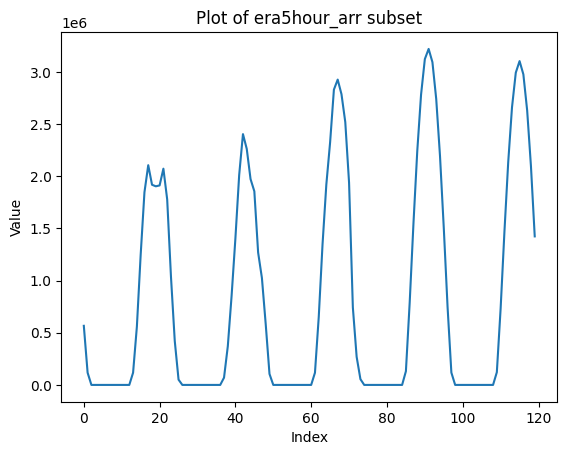

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y = era5hour_arr[4, 6000:6120, 0]
x = np.arange(len(y))

plt.plot(x, y)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of era5hour_arr subset')
plt.show()

In [ ]:
start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
end_datetime = datetime.strptime(end_date, '%Y-%m-%d')  # end_date
current_datetime = start_datetime
tfirsts = []
tlasts = []
deltaa = 24 # hours
while current_datetime < end_datetime:
  tfirsts.append(current_datetime)
  tlasts.append( current_datetime + timedelta(hours=deltaa))
  current_datetime += timedelta(hours=deltaa)

print(len(tfirsts))

3288


In [ ]:
# @title parallel processing  for HLSL30
import concurrent.futures


def process_day(idx, feature_collection_crop):
  print(f'is running the {idx}th group')
  tfirst = tfirsts[idx]
  tlast = tlasts[idx]

  HLSL30_sub = HLSL30.filterDate(tfirst, tlast)
  Sentinel2_sub = Sentinel2.filterDate(tfirst, tlast)
  sentinel1_sub = Sentinel1.filterDate(tfirst, tlast)

  def sample_with_time(image):
        samples = image.sampleRegions(
            collection=feature_collection_crop,
            scale=100
        )
        return samples.map(lambda f: f.set('system:time_start', image.get('system:time_start')))

  # sentinel2
  Sentinel2_sampled_points = Sentinel2_sub.map(sample_with_time).flatten()
  points_list = Sentinel2_sampled_points.getInfo()['features']
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  # print('sentinel2: ',len(df))
  if 'id_num' in df.columns:
    df['datetime'] = pd.to_datetime(df['system:time_start'], unit='ms')
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = ((df['datetime'] - start_datetime).dt.total_seconds() / 3600).astype(int)
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      Sentinel2_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'B2']
      Sentinel2_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'B3']
      Sentinel2_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'B4']
      Sentinel2_arr[3, idx[0], idx[1]] = grouped_df.loc[idx, 'B5']
      Sentinel2_arr[4, idx[0], idx[1]] = grouped_df.loc[idx, 'B6']
      Sentinel2_arr[5, idx[0], idx[1]] = grouped_df.loc[idx, 'B7']
      Sentinel2_arr[6, idx[0], idx[1]] = grouped_df.loc[idx, 'B8']
      Sentinel2_arr[7, idx[0], idx[1]] = grouped_df.loc[idx, 'B8A']
      Sentinel2_arr[8, idx[0], idx[1]] = grouped_df.loc[idx, 'B11']
      Sentinel2_arr[9, idx[0], idx[1]] = grouped_df.loc[idx, 'B12']

  # hlsl30
  HLSL30_sampled_points = HLSL30_sub.map(sample_with_time).flatten()
  points_list = HLSL30_sampled_points.getInfo()['features']
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  # print('hlsl30: ',len(df))
  if 'id_num' in df.columns:
    df['datetime'] = pd.to_datetime(df['system:time_start'], unit='ms')
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = ((df['datetime'] - start_datetime).dt.total_seconds() / 3600).astype(int)
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      HLSL30_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'B2']
      HLSL30_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'B3']
      HLSL30_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'B4']
      HLSL30_arr[3, idx[0], idx[1]] = grouped_df.loc[idx, 'B5']
      HLSL30_arr[4, idx[0], idx[1]] = grouped_df.loc[idx, 'B6']
      HLSL30_arr[5, idx[0], idx[1]] = grouped_df.loc[idx, 'B7']
      HLSL30_arr[6, idx[0], idx[1]] = grouped_df.loc[idx, 'B9']
      HLSL30_arr[7, idx[0], idx[1]] = grouped_df.loc[idx, 'B10']
      HLSL30_arr[8, idx[0], idx[1]] = grouped_df.loc[idx, 'B11']

  # sentinel1
  sentinel1_sampled_points = sentinel1_sub.map(sample_with_time).flatten()
  points_list = sentinel1_sampled_points.getInfo()['features']
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  # print('sentinel1: ',len(df))
  if 'id_num' in df.columns:
    df['datetime'] = pd.to_datetime(df['system:time_start'], unit='ms')
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = ((df['datetime'] - start_datetime).dt.total_seconds() / 3600).astype(int)
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      sentinel1_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'VV']
      sentinel1_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'VH']
      sentinel1_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'angle']


  return idx



if os.path.exists('Sentinel2_arr.npy'):
  Sentinel2_arr = np.load('Sentinel2_arr.npy')
  HLSL30_arr = np.load('HLSL30_arr.npy')
  sentinel1_arr = np.load('sentinel1_arr.npy')
else:
  with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
        results = list(executor.map(lambda idx: process_day(idx, feature_collection), range(len(tfirsts)))) # len(tfirsts)
  print('done')
  np.save('Sentinel2_arr.npy', Sentinel2_arr)
  np.save('HLSL30_arr.npy', HLSL30_arr)
  np.save('sentinel1_arr.npy', sentinel1_arr)

time.sleep(10)
# from google.colab import files
# files.download('Sentinel2_arr.npy')
# files.download('HLSL30_arr.npy')
# files.download('sentinel1_arr.npy')

In [ ]:
print('shape of HLSL30_arr: ',HLSL30_arr.shape)
print('shape of sentinel1_arr: ',sentinel1_arr.shape)
print('shape of Sentinel2_arr: ',Sentinel2_arr.shape)
print('NON-nan numbers: ',np.count_nonzero(~np.isnan(HLSL30_arr)))
print('NON-nan numbers: ',np.count_nonzero(~np.isnan(sentinel1_arr)))
print('NON-nan numbers: ',np.count_nonzero(~np.isnan(Sentinel2_arr)))


shape of HLSL30_arr:  (9, 78912, 465)
shape of sentinel1_arr:  (3, 78912, 465)
shape of Sentinel2_arr:  (10, 78912, 465)
NON-nan numbers:  615817
NON-nan numbers:  509448
NON-nan numbers:  1508533


In [ ]:
# @title ERA5 processing

#========================short term====================

ear5_d2m_arr_new = era5hour_arr[1, :, :].copy()
print(ear5_d2m_arr_new.shape)
ear5_t2m_arr_new = era5hour_arr[0, :, :].copy()
ear5_wind_arr_new = era5hour_arr[2, :, :].copy()
ear5_sp_arr_new = era5hour_arr[3, :, :].copy()
for row_idx in range(24, ear5_d2m_arr_new.shape[0]):
    ear5_d2m_arr_new[row_idx, :] = np.sum(era5hour_arr[1, row_idx - 23: row_idx + 1, :] * short_term_weights[:, np.newaxis], axis=0)
    ear5_t2m_arr_new[row_idx, :] = np.sum(era5hour_arr[0, row_idx - 23: row_idx + 1, :] * short_term_weights[:, np.newaxis], axis=0)
    ear5_wind_arr_new[row_idx, :] = np.sum(era5hour_arr[2, row_idx - 23: row_idx + 1, :] * short_term_weights[:, np.newaxis], axis=0)
    ear5_sp_arr_new[row_idx, :] = np.sum(era5hour_arr[3, row_idx - 23: row_idx + 1, :] * short_term_weights[:, np.newaxis], axis=0)


# ========================middle term====================

ear5_ssr_arr_new = era5hour_arr[4, :, :].copy()
ear5_str_arr_new = era5hour_arr[5, :, :].copy()
for row_idx in range(72, ear5_str_arr_new.shape[0]):
    ear5_ssr_arr_new[row_idx, :] = np.sum(era5hour_arr[4, row_idx - 71: row_idx + 1, :] * mid_term_weights[:, np.newaxis], axis=0)
    ear5_str_arr_new[row_idx, :] = np.sum(era5hour_arr[5, row_idx - 71: row_idx + 1, :] * mid_term_weights[:, np.newaxis], axis=0)


# ========================long term====================
ear5_e_arr_new = era5hour_arr[6, :, :].copy()
ear5_tp_arr_new = era5hour_arr[7, :, :].copy()
for row_idx in range(120, ear5_e_arr_new.shape[0]):
    ear5_e_arr_new[row_idx, :] = np.sum(era5hour_arr[6, row_idx - 119: row_idx + 1, :] * long_term_weights[:, np.newaxis] , axis=0)
    ear5_tp_arr_new[row_idx, :] = np.sum(era5hour_arr[7, row_idx - 119: row_idx + 1, :] * long_term_weights[:, np.newaxis], axis=0)


(78912, 465)


In [ ]:
print('shape of ear5_d2m_arr_new: ',ear5_d2m_arr_new.shape)
print('shape of ear5_t2m_arr_new: ',ear5_t2m_arr_new.shape)
print('shape of ear5_wind_arr_new: ',ear5_wind_arr_new.shape)
print('shape of ear5_sp_arr_new: ',ear5_sp_arr_new.shape)
print('shape of ear5_ssr_arr_new: ',ear5_ssr_arr_new.shape)
print('shape of ear5_str_arr_new: ',ear5_str_arr_new.shape)
print('shape of ear5_e_arr_new: ',ear5_e_arr_new.shape)
print('shape of ear5_tp_arr_new: ',ear5_tp_arr_new.shape)

shape of ear5_d2m_arr_new:  (78912, 465)
shape of ear5_t2m_arr_new:  (78912, 465)
shape of ear5_wind_arr_new:  (78912, 465)
shape of ear5_sp_arr_new:  (78912, 465)
shape of ear5_ssr_arr_new:  (78912, 465)
shape of ear5_str_arr_new:  (78912, 465)
shape of ear5_e_arr_new:  (78912, 465)
shape of ear5_tp_arr_new:  (78912, 465)


In [ ]:
obs_sm_root_arr.T.shape

(78912, 465)

In [ ]:
#@title Remove inf values of Sentinel 1 - there are some but I do not know why
sentinel1_arr[sentinel1_arr>1000] = np.nan

In [ ]:
# @title Prepare Xy for ML and store them in npy file
"""-------------------------------------sentinel1-rootzone--------------------------------------"""
# X - ID, year, doy, hour, latitude, longitude, dem, slope, sinAspect, cosAspect, TWI,
# bd, sand, clay, ksat, SMAP, d2m, t2m, ssr,str, e, wind, sp, tp,
# VV, VH, angle, CR,  DPSVIm, Pol  - 30
num_ids = len(refer_id_arr)
X = np.zeros((30, num_hours, num_ids))
X[:] = np.nan
X[0] = np.tile(referIDArr, (num_hours, 1))
X[1] = np.repeat(year_list[:, np.newaxis], num_ids, axis=1)
X[2] = np.repeat(doy_list[:, np.newaxis], num_ids, axis=1)
X[3] = np.repeat(hour_list[:, np.newaxis], num_ids, axis=1)
X[4] = np.tile(refer_lat_arr, (num_hours, 1))
X[5] = np.tile(refer_lon_arr, (num_hours, 1))
X[6] = np.tile(elevation_arr, (num_hours, 1))
X[7] = np.tile(slopeDegree_arr, (num_hours, 1))
X[8] = np.tile(sinAsp_arr, (num_hours, 1))
X[9] = np.tile(cosAsp_arr, (num_hours, 1))
X[10] = np.tile(TWII_arr, (num_hours, 1))
X[11] = np.tile(ml_bd_0_100, (num_hours, 1))
X[12] = np.tile(ml_sand_0_100, (num_hours, 1))
X[13] = np.tile(ml_clay_0_100, (num_hours, 1))
X[14] = np.tile(ml_ksat_0_100, (num_hours, 1))
X[15] = 0.3 # smap4_root_arr.T
X[16] = ear5_d2m_arr_new
X[17] = ear5_t2m_arr_new
X[18] = ear5_ssr_arr_new
X[19] = ear5_str_arr_new
X[20] = ear5_e_arr_new
X[21] = ear5_wind_arr_new
X[22] = ear5_sp_arr_new
X[23] = ear5_tp_arr_new
X[24] = sentinel1_arr[0, :, :]
X[25] = sentinel1_arr[1, :, :]
X[26] = sentinel1_arr[2, :, :]
X[27] = sentinel1_arr[0, :, :] / sentinel1_arr[1, :, :]
X[28] = (sentinel1_arr[0, :, :]**2 + sentinel1_arr[1, :, :]**2)/np.sqrt(2)
X[29] = (sentinel1_arr[0, :, :] + sentinel1_arr[1, :, :]) / (sentinel1_arr[0, :, :] - sentinel1_arr[1, :, :])

X = X.reshape((30, num_hours*num_ids))

y = np.zeros((num_hours, num_ids))
y[:] = obs_sm_root_arr.T
y = y.reshape(1, -1)

X_mask = ~np.any(np.isnan(X), axis=0)
y_mask = ~np.isnan(y[0])

X_all = X[:, X_mask].T
X_valid = X[:, X_mask & y_mask].T
y_valid = y[:, X_mask & y_mask].T

print(X_all.shape)
print(X_valid.shape)
print(y_valid.shape)
print(np.count_nonzero(np.isnan(X_all)))
print(np.count_nonzero(np.isnan(X_valid)))
print(np.count_nonzero(np.isnan(y_valid)))

np.save('sentinel1_rootzone_X_all.npy', X_all)
np.save('sentinel1_rootzone_X_valid.npy', X_valid)
np.save('sentinel1_rootzone_y_valid.npy', y_valid)

"""-------------------------------------sentinel1-surface--------------------------------------"""
# X - ID, year, doy, hour, latitude, longitude, dem, slope, sinAspect, cosAspect, TWI,
# bd, sand, clay, ksat, SMAP, d2m, t2m, ssr,str, e, wind, sp, tp,
# VV, VH, angle, CR,  DPSVIm, Pol  - 30
X = np.zeros((30, num_hours, num_ids))
X[:] = np.nan
X[0] = np.tile(referIDArr, (num_hours, 1))
X[1] = np.repeat(year_list[:, np.newaxis], num_ids, axis=1)
X[2] = np.repeat(doy_list[:, np.newaxis], num_ids, axis=1)
X[3] = np.repeat(hour_list[:, np.newaxis], num_ids, axis=1)
X[4] = np.tile(refer_lat_arr, (num_hours, 1))
X[5] = np.tile(refer_lon_arr, (num_hours, 1))
X[6] = np.tile(elevation_arr, (num_hours, 1))
X[7] = np.tile(slopeDegree_arr, (num_hours, 1))
X[8] = np.tile(sinAsp_arr, (num_hours, 1))
X[9] = np.tile(cosAsp_arr, (num_hours, 1))
X[10] = np.tile(TWII_arr, (num_hours, 1))
X[11] = np.tile(ml_bd_0_100, (num_hours, 1))
X[12] = np.tile(ml_sand_0_100, (num_hours, 1))
X[13] = np.tile(ml_clay_0_100, (num_hours, 1))
X[14] = np.tile(ml_ksat_0_100, (num_hours, 1))
X[15] = 0.3 #smap4_surface_arr.T
X[16] = ear5_d2m_arr_new
X[17] = ear5_t2m_arr_new
X[18] = ear5_ssr_arr_new
X[19] = ear5_str_arr_new
X[20] = ear5_e_arr_new
X[21] = ear5_wind_arr_new
X[22] = ear5_sp_arr_new
X[23] = ear5_tp_arr_new
X[24] = sentinel1_arr[0, :, :]
X[25] = sentinel1_arr[1, :, :]
X[26] = sentinel1_arr[2, :, :]
X[27] = sentinel1_arr[0, :, :] / sentinel1_arr[1, :, :]
X[28] = (sentinel1_arr[0, :, :] ** 2 + sentinel1_arr[1, :, :] ** 2) / np.sqrt(2)
X[29] = (sentinel1_arr[0, :, :] + sentinel1_arr[1, :, :]) / (sentinel1_arr[0, :, :] - sentinel1_arr[1, :, :])

X = X.reshape((30, num_hours * num_ids))

y = np.zeros((num_hours, num_ids))
y[:] = obs_sm_surface_arr.T
y = y.reshape(1, -1)

X_mask = ~np.any(np.isnan(X), axis=0)
y_mask = ~np.isnan(y[0])

X_all = X[:, X_mask].T
X_valid = X[:, X_mask & y_mask].T
y_valid = y[:, X_mask & y_mask].T

print(X_all.shape)
print(X_valid.shape)
print(y_valid.shape)
print(np.count_nonzero(np.isnan(X_all)))
print(np.count_nonzero(np.isnan(X_valid)))
print(np.count_nonzero(np.isnan(y_valid)))

np.save('sentinel1_surface_X_all.npy', X_all)
np.save('sentinel1_surface_X_valid.npy', X_valid)
np.save('sentinel1_surface_y_valid.npy', y_valid)

"""-------------------------------------sentinel2-rootzone--------------------------------------"""
# X - ID, year, doy, hour, latitude, longitude, dem, slope, sinAspect, cosAspect, TWI,
# bd, sand, clay, ksat, SMAP, d2m, t2m, ssr,str, e, wind, sp, tp, - 24
# B2, B3, B4, B5, B6, B7, B8, B8A, B11, B12, NDVI, NDWI, greenness, brightness, wetness  - 39
X = np.zeros((39, num_hours, num_ids))
X[:] = np.nan
X[0] = np.tile(referIDArr, (num_hours, 1))
X[1] = np.repeat(year_list[:, np.newaxis], num_ids, axis=1)
X[2] = np.repeat(doy_list[:, np.newaxis], num_ids, axis=1)
X[3] = np.repeat(hour_list[:, np.newaxis], num_ids, axis=1)
X[4] = np.tile(refer_lat_arr, (num_hours, 1))
X[5] = np.tile(refer_lon_arr, (num_hours, 1))
X[6] = np.tile(elevation_arr, (num_hours, 1))
X[7] = np.tile(slopeDegree_arr, (num_hours, 1))
X[8] = np.tile(sinAsp_arr, (num_hours, 1))
X[9] = np.tile(cosAsp_arr, (num_hours, 1))
X[10] = np.tile(TWII_arr, (num_hours, 1))
X[11] = np.tile(ml_bd_0_100, (num_hours, 1))
X[12] = np.tile(ml_sand_0_100, (num_hours, 1))
X[13] = np.tile(ml_clay_0_100, (num_hours, 1))
X[14] = np.tile(ml_ksat_0_100, (num_hours, 1))
X[15] = 0.3 #smap4_surface_arr.T
X[16] = ear5_d2m_arr_new
X[17] = ear5_t2m_arr_new
X[18] = ear5_ssr_arr_new
X[19] = ear5_str_arr_new
X[20] = ear5_e_arr_new
X[21] = ear5_wind_arr_new
X[22] = ear5_sp_arr_new
X[23] = ear5_tp_arr_new
X[24] = Sentinel2_arr[0, :, :] * 0.0001 # B2
X[25] = Sentinel2_arr[1, :, :] * 0.0001 # B3
X[26] = Sentinel2_arr[2, :, :] * 0.0001 # B4
X[27] = Sentinel2_arr[3, :, :] * 0.0001 # B5
X[28] = Sentinel2_arr[4, :, :] * 0.0001 # B6
X[29] = Sentinel2_arr[5, :, :] * 0.0001 # B7
X[30] = Sentinel2_arr[6, :, :] * 0.0001 # B8
X[31] = Sentinel2_arr[7, :, :] * 0.0001 # B8A
X[32] = Sentinel2_arr[8, :, :] * 0.0001 # B11
X[33] = Sentinel2_arr[9, :, :] * 0.0001 # B12
X[34] = (X[30] - X[26])/(X[30] + X[26])  # NDVI
X[35] = (X[25] - X[30])/(X[25] + X[30])  # NDWI
X[36] = -0.3599 * X[24] - 0.3533 * X[25] - 0.4734 * X[26] + 0.6633 * X[30] - 0.0087 * X[32] - 0.2856 * X[33] # greenness
X[37] = 0.3510 * X[24] + 0.3813 * X[25] + 0.3437 * X[26] + 0.7196 * X[30] + 0.2396 * X[32] + 0.1949 * X[33]  # brightness
X[38] = 0.2578 * X[24] + 0.2305 * X[25] + 0.0883 * X[26] + 0.1071 * X[30] - 0.7611 * X[32] - 0.5308 * X[33]  # wetness

print('sentinel2-rootzone')
print('mean NDVI: ', np.nanmean(X[34]))
print('mean NDWI: ', np.nanmean(X[35]))
print('mean greenness: ', np.nanmean(X[36]))
print('mean brightness: ', np.nanmean(X[37]))
print('mean wetness: ', np.nanmean(X[38]))

X = X.reshape((39, num_hours * num_ids))

y = np.zeros((num_hours, num_ids))
y[:] = obs_sm_root_arr.T
y = y.reshape(1, -1)

X_mask = ~np.any(np.isnan(X), axis=0)
y_mask = ~np.isnan(y[0])

X_all = X[:, X_mask].T
X_valid = X[:, X_mask & y_mask].T
y_valid = y[:, X_mask & y_mask].T

print(X_all.shape)
print(X_valid.shape)
print(y_valid.shape)
print(np.count_nonzero(np.isnan(X_all)))
print(np.count_nonzero(np.isnan(X_valid)))
print(np.count_nonzero(np.isnan(y_valid)))

np.save('sentinel2_rootzone_X_all.npy', X_all)
np.save('sentinel2_rootzone_X_valid.npy', X_valid)
np.save('sentinel2_rootzone_y_valid.npy', y_valid)

"""-------------------------------------sentinel2-surface--------------------------------------"""
# X - ID, year, doy, hour, latitude, longitude, dem, slope, sinAspect, cosAspect, TWI,
# bd, sand, clay, ksat, SMAP, d2m, t2m, ssr,str, e, wind, sp, tp,- 24
#     # B2, B3, B4, B5, B6, B7, B8, B8A, B11, B12, NDVI, NDWI, greenness, brightness, wetness  - 39
X = np.zeros((39, num_hours, num_ids))
X[:] = np.nan
X[0] = np.tile(referIDArr, (num_hours, 1))
X[1] = np.repeat(year_list[:, np.newaxis], num_ids, axis=1)
X[2] = np.repeat(doy_list[:, np.newaxis], num_ids, axis=1)
X[3] = np.repeat(hour_list[:, np.newaxis], num_ids, axis=1)
X[4] = np.tile(refer_lat_arr, (num_hours, 1))
X[5] = np.tile(refer_lon_arr, (num_hours, 1))
X[6] = np.tile(elevation_arr, (num_hours, 1))
X[7] = np.tile(slopeDegree_arr, (num_hours, 1))
X[8] = np.tile(sinAsp_arr, (num_hours, 1))
X[9] = np.tile(cosAsp_arr, (num_hours, 1))
X[10] = np.tile(TWII_arr, (num_hours, 1))
X[11] = np.tile(ml_bd_0_100, (num_hours, 1))
X[12] = np.tile(ml_sand_0_100, (num_hours, 1))
X[13] = np.tile(ml_clay_0_100, (num_hours, 1))
X[14] = np.tile(ml_ksat_0_100, (num_hours, 1))
X[15] = 0.3 #smap4_surface_arr.T
X[16] = ear5_d2m_arr_new
X[17] = ear5_t2m_arr_new
X[18] = ear5_ssr_arr_new
X[19] = ear5_str_arr_new
X[20] = ear5_e_arr_new
X[21] = ear5_wind_arr_new
X[22] = ear5_sp_arr_new
X[23] = ear5_tp_arr_new
X[24] = Sentinel2_arr[0, :, :] * 0.0001 # B2
X[25] = Sentinel2_arr[1, :, :] * 0.0001 # B3
X[26] = Sentinel2_arr[2, :, :] * 0.0001 # B4
X[27] = Sentinel2_arr[3, :, :] * 0.0001 # B5
X[28] = Sentinel2_arr[4, :, :] * 0.0001 # B6
X[29] = Sentinel2_arr[5, :, :] * 0.0001 # B7
X[30] = Sentinel2_arr[6, :, :] * 0.0001 # B8
X[31] = Sentinel2_arr[7, :, :] * 0.0001 # B8A
X[32] = Sentinel2_arr[8, :, :] * 0.0001 # B11
X[33] = Sentinel2_arr[9, :, :] * 0.0001 # B12
X[34] = (X[30] - X[26])/(X[30] + X[26])  # NDVI
X[35] = (X[25] - X[30])/(X[25] + X[30])  # NDWI
X[36] = -0.3599 * X[24] - 0.3533 * X[25] - 0.4734 * X[26] + 0.6633 * X[30] - 0.0087 * X[32] - 0.2856 * X[33] # greenness
X[37] = 0.3510 * X[24] + 0.3813 * X[25] + 0.3437 * X[26] + 0.7196 * X[30] + 0.2396 * X[32] + 0.1949 * X[33]  # brightness
X[38] = 0.2578 * X[24] + 0.2305 * X[25] + 0.0883 * X[26] + 0.1071 * X[30] - 0.7611 * X[32] - 0.5308 * X[33]  # wetness

print('sentinel2-surface')
print('mean NDVI: ', np.nanmean(X[34]))
print('mean NDWI: ', np.nanmean(X[35]))
print('mean greenness: ', np.nanmean(X[36]))
print('mean brightness: ', np.nanmean(X[37]))
print('mean wetness: ', np.nanmean(X[38]))

X = X.reshape((39, num_hours * num_ids))

y = np.zeros((num_hours, num_ids))
y[:] = obs_sm_surface_arr.T
y = y.reshape(1, -1)

X_mask = ~np.any(np.isnan(X), axis=0)
y_mask = ~np.isnan(y[0])

X_all = X[:, X_mask].T
X_valid = X[:, X_mask & y_mask].T
y_valid = y[:, X_mask & y_mask].T

print(X_all.shape)
print(X_valid.shape)
print(y_valid.shape)
print(np.count_nonzero(np.isnan(X_all)))
print(np.count_nonzero(np.isnan(X_valid)))
print(np.count_nonzero(np.isnan(y_valid)))

np.save('sentinel2_surface_X_all.npy', X_all)
np.save('sentinel2_surface_X_valid.npy', X_valid)
np.save('sentinel2_surface_y_valid.npy', y_valid)

"""-------------------------------------HLSL30-rootzone--------------------------------------"""
# X - ID, year, doy, hour, latitude, longitude, dem, slope, sinAspect, cosAspect, TWI,
# bd, sand, clay, ksat, SMAP, d2m, t2m, ssr,str, e, wind, sp, tp, - 24
# B2, B3, B4, B5, B6, B7, B10, B11, SZA, SAA, VZA, VAA, NDVI, NDWI, greenness, brightness, wetness  - 41
X = np.zeros((41, num_hours, num_ids))
X[:] = np.nan
X[0] = np.tile(referIDArr, (num_hours, 1))
X[1] = np.repeat(year_list[:, np.newaxis], num_ids, axis=1)
X[2] = np.repeat(doy_list[:, np.newaxis], num_ids, axis=1)
X[3] = np.repeat(hour_list[:, np.newaxis], num_ids, axis=1)
X[4] = np.tile(refer_lat_arr, (num_hours, 1))
X[5] = np.tile(refer_lon_arr, (num_hours, 1))
X[6] = np.tile(elevation_arr, (num_hours, 1))
X[7] = np.tile(slopeDegree_arr, (num_hours, 1))
X[8] = np.tile(sinAsp_arr, (num_hours, 1))
X[9] = np.tile(cosAsp_arr, (num_hours, 1))
X[10] = np.tile(TWII_arr, (num_hours, 1))
X[11] = np.tile(ml_bd_0_100, (num_hours, 1))
X[12] = np.tile(ml_sand_0_100, (num_hours, 1))
X[13] = np.tile(ml_clay_0_100, (num_hours, 1))
X[14] = np.tile(ml_ksat_0_100, (num_hours, 1))
X[15] = 0.3 #smap4_surface_arr.T
X[16] = ear5_d2m_arr_new
X[17] = ear5_t2m_arr_new
X[18] = ear5_ssr_arr_new
X[19] = ear5_str_arr_new
X[20] = ear5_e_arr_new
X[21] = ear5_wind_arr_new
X[22] = ear5_sp_arr_new
X[23] = ear5_tp_arr_new
X[24] = HLSL30_arr[0, :, :]  # B2
X[25] = HLSL30_arr[1, :, :]   # B3
X[26] = HLSL30_arr[2, :, :]   # B4
X[27] = HLSL30_arr[3, :, :]   # B5
X[28] = HLSL30_arr[4, :, :]  # B6
X[29] = HLSL30_arr[5, :, :]   # B7
X[30] = HLSL30_arr[7, :, :]   # B10
X[31] = HLSL30_arr[8, :, :]   # B11
X[32] = 90 #HLSL30_arr[9, :, :]   # SZA
X[33] = 90 #HLSL30_arr[10, :, :]  # SAA
X[34] = 90 #HLSL30_arr[11, :, :]  # VZA
X[35] = 90 #HLSL30_arr[12, :, :]  # VAA
X[36] = (X[27] - X[26]) / (X[27] + X[26])  # NDVI
X[37] = (X[25] - X[27]) / (X[25] + X[27])  # NDWI
X[38] = -0.2941 * X[24] - 0.243 * X[25] - 0.5424 * X[26] +0.7276 * X[27] +0.0713 * X[28] - 0.1608 * X[29]  # greenness
X[39] = 0.3510 * X[24] + 0.3813 * X[25] + 0.3437 * X[26] + 0.7196 * X[27] + 0.2396 * X[28] + 0.1949 * X[29]  # brightness
X[40] = 0.2578 * X[24] + 0.2305 * X[25] + 0.0883 * X[26] + 0.1071 * X[27] - 0.7611 * X[28] - 0.5308 * X[29]  # wetness

print('HLSL30-rootzone')
print('mean NDVI: ', np.nanmean(X[36]))
print('mean NDWI: ', np.nanmean(X[37]))
print('mean greenness: ', np.nanmean(X[38]))
print('mean brightness: ', np.nanmean(X[39]))
print('mean wetness: ', np.nanmean(X[40]))

X = X.reshape((41, num_hours * num_ids))

y = np.zeros((num_hours, num_ids))
y[:] = obs_sm_root_arr.T
y = y.reshape(1, -1)

X_mask = ~np.any(np.isnan(X), axis=0)
y_mask = ~np.isnan(y[0])

X_all = X[:, X_mask].T
X_valid = X[:, X_mask & y_mask].T
y_valid = y[:, X_mask & y_mask].T

print(X_all.shape)
print(X_valid.shape)
print(y_valid.shape)
print(np.count_nonzero(np.isnan(X_all)))
print(np.count_nonzero(np.isnan(X_valid)))
print(np.count_nonzero(np.isnan(y_valid)))

np.save('HLSL30_rootzone_X_all.npy', X_all)
np.save('HLSL30_rootzone_X_valid.npy', X_valid)
np.save('HLSL30_rootzone_y_valid.npy', y_valid)

"""-------------------------------------HLSL30-surface--------------------------------------"""
# X - ID, year, doy, hour, latitude, longitude, dem, slope, sinAspect, cosAspect, TWI,
# bd, sand, clay, ksat, SMAP, d2m, t2m, ssr,str, e, wind, sp, tp,- 24
#    B2, B3, B4, B5, B6, B7, B10, B11, SZA, SAA, VZA, VAA, NDVI, NDWI, greenness, brightness, wetness  - 41
X = np.zeros((41, num_hours, num_ids))
X[:] = np.nan
X[0] = np.tile(referIDArr, (num_hours, 1))
X[1] = np.repeat(year_list[:, np.newaxis], num_ids, axis=1)
X[2] = np.repeat(doy_list[:, np.newaxis], num_ids, axis=1)
X[3] = np.repeat(hour_list[:, np.newaxis], num_ids, axis=1)
X[4] = np.tile(refer_lat_arr, (num_hours, 1))
X[5] = np.tile(refer_lon_arr, (num_hours, 1))
X[6] = np.tile(elevation_arr, (num_hours, 1))
X[7] = np.tile(slopeDegree_arr, (num_hours, 1))
X[8] = np.tile(sinAsp_arr, (num_hours, 1))
X[9] = np.tile(cosAsp_arr, (num_hours, 1))
X[10] = np.tile(TWII_arr, (num_hours, 1))
X[11] = np.tile(ml_bd_0_100, (num_hours, 1))
X[12] = np.tile(ml_sand_0_100, (num_hours, 1))
X[13] = np.tile(ml_clay_0_100, (num_hours, 1))
X[14] = np.tile(ml_ksat_0_100, (num_hours, 1))
X[15] = 0.3 #smap4_surface_arr.T
X[16] = ear5_d2m_arr_new
X[17] = ear5_t2m_arr_new
X[18] = ear5_ssr_arr_new
X[19] = ear5_str_arr_new
X[20] = ear5_e_arr_new
X[21] = ear5_wind_arr_new
X[22] = ear5_sp_arr_new
X[23] = ear5_tp_arr_new
X[24] = HLSL30_arr[0, :, :]  # B2
X[25] = HLSL30_arr[1, :, :]  # B3
X[26] = HLSL30_arr[2, :, :]  # B4
X[27] = HLSL30_arr[3, :, :]  # B5
X[28] = HLSL30_arr[4, :, :]  # B6
X[29] = HLSL30_arr[5, :, :]  # B7
X[30] = HLSL30_arr[7, :, :] # B10
X[31] = HLSL30_arr[8, :, :]  # B11
X[32] = 90 #HLSL30_arr[9, :, :]  # SZA
X[33] = 90 #HLSL30_arr[10, :, :]  # SAA
X[34] = 90 #HLSL30_arr[11, :, :]  # VZA
X[35] = 90 #HLSL30_arr[12, :, :]  # VAA
X[36] = (X[27] - X[26]) / (X[27] + X[26])  # NDVI
X[37] = (X[25] - X[27]) / (X[25] + X[27])  # NDWI
X[38] = -0.2941 * X[24] - 0.243 * X[25] - 0.5424 * X[26] +0.7276 * X[27] +0.0713 * X[28] - 0.1608 * X[29]  # greenness
X[39] = 0.3510 * X[24] + 0.3813 * X[25] + 0.3437 * X[26] + 0.7196 * X[27] + 0.2396 * X[28] + 0.1949 * X[29]  # brightness
X[40] = 0.2578 * X[24] + 0.2305 * X[25] + 0.0883 * X[26] + 0.1071 * X[27] - 0.7611 * X[28] - 0.5308 * X[29]  # wetness

print('HLSL30-surface')
print('mean NDVI: ', np.nanmean(X[36]))
print('mean NDWI: ', np.nanmean(X[37]))
print('mean greenness: ', np.nanmean(X[38]))
print('mean brightness: ', np.nanmean(X[39]))
print('mean wetness: ', np.nanmean(X[40]))

X = X.reshape((41, num_hours * num_ids))

y = np.zeros((num_hours, num_ids))
y[:] = obs_sm_surface_arr.T
y = y.reshape(1, -1)

X_mask = ~np.any(np.isnan(X), axis=0)
y_mask = ~np.isnan(y[0])

X_all = X[:, X_mask].T
X_valid = X[:, X_mask & y_mask].T
y_valid = y[:, X_mask & y_mask].T

print(X_all.shape)
print(X_valid.shape)
print(y_valid.shape)
print(np.count_nonzero(np.isnan(X_all)))
print(np.count_nonzero(np.isnan(X_valid)))
print(np.count_nonzero(np.isnan(y_valid)))

np.save('HLSL30_surface_X_all.npy', X_all)
np.save('HLSL30_surface_X_valid.npy', X_valid)
np.save('HLSL30_surface_y_valid.npy', y_valid)


print()

(165922, 30)
(24538, 30)
(24538, 1)
0
0
0
(165922, 30)
(37599, 30)
(37599, 1)
0
0
0
sentinel2-rootzone
mean NDVI:  0.4808724383791793
mean NDWI:  -0.5118954785707435
mean greenness:  0.03654766765533724
mean brightness:  0.41780215115326946
mean wetness:  -0.229207170217558
(148287, 39)
(25618, 39)
(25618, 1)
0
0
0
sentinel2-surface
mean NDVI:  0.4808724383791793
mean NDWI:  -0.5118954785707435
mean greenness:  0.03654766765533724
mean brightness:  0.41780215115326946
mean wetness:  -0.229207170217558
(148287, 39)
(36867, 39)
(36867, 1)
0
0
0
HLSL30-rootzone
mean NDVI:  0.5183910973628286
mean NDWI:  -0.5567367822884184
mean greenness:  0.12919313202714333
mean brightness:  0.4046851359877852
mean wetness:  -0.22218546784597007
(66765, 41)
(11500, 41)
(11500, 1)
0
0
0
HLSL30-surface
mean NDVI:  0.5183910973628286
mean NDWI:  -0.5567367822884184
mean greenness:  0.12919313202714333
mean brightness:  0.4046851359877852
mean wetness:  -0.22218546784597007
(66765, 41)
(16722, 41)
(16722, 1

In [ ]:
#@title Download the files if you need run offline
from google.colab import files
import os

# List all files in the current directory (root folder)
files_to_download = [f for f in os.listdir('.') if os.path.isfile(f) and f.endswith(('_all.npy', '_valid.npy'))]

for file_name in files_to_download:
  try:
    files.download(file_name)
  except Exception as e:
    print(f"Error downloading {file_name}: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
np.set_printoptions(suppress=True, precision=6, floatmode='fixed')

HLSL30_surface_X_all = np.load('HLSL30_surface_X_all.npy')
print(np.nanmean(HLSL30_surface_X_all, axis=0))
HLSL30_rootzone_X_all = np.load('HLSL30_rootzone_X_all.npy')
print(np.nanmean(HLSL30_rootzone_X_all, axis=0))
sentinel2_rootzone_X_all = np.load('sentinel2_rootzone_X_all.npy')
print(np.nanmean(sentinel2_rootzone_X_all, axis=0))
sentinel2_surface_X_all = np.load('sentinel2_surface_X_all.npy')
print(np.nanmean(sentinel2_surface_X_all, axis=0))
sentinel1_rootzone_X_all = np.load('sentinel1_rootzone_X_all.npy')
print(np.nanmean(sentinel1_rootzone_X_all, axis=0))
sentinel1_surface_X_all = np.load('sentinel1_surface_X_all.npy')
print(np.nanmean(sentinel1_surface_X_all, axis=0))
#
HLSL30_surface_X_valid = np.load('HLSL30_surface_X_valid.npy')
print(np.nanmean(HLSL30_surface_X_valid, axis=0))
HLSL30_rootzone_X_valid = np.load('HLSL30_rootzone_X_valid.npy')
print(np.nanmean(HLSL30_rootzone_X_valid, axis=0))
sentinel2_rootzone_X_valid = np.load('sentinel2_rootzone_X_valid.npy')
print(np.nanmean(sentinel2_rootzone_X_valid, axis=0))
sentinel2_surface_X_valid = np.load('sentinel2_surface_X_valid.npy')
print(np.nanmean(sentinel2_surface_X_valid, axis=0))
sentinel1_rootzone_X_valid = np.load('sentinel1_rootzone_X_valid.npy')
print(np.nanmean(sentinel1_rootzone_X_valid, axis=0))
sentinel1_surface_X_valid = np.load('sentinel1_surface_X_valid.npy')
print(np.nanmean(sentinel1_surface_X_valid, axis=0))


[   1579.325605    2020.817794     198.595537      15.819112
      37.424208     -86.482091     273.308105       1.032325
       0.080287      -0.062593       5.458815       1.430556
      35.511793      24.362291       2.216308       0.300000
     280.994148     288.633504  970320.707331 1138961.245793
      -0.000122       2.656070   98623.544109       0.000055
       0.052876       0.084250       0.094932       0.309300
       0.269602       0.173187      20.730782      19.358630
      90.000000      90.000000      90.000000      90.000000
       0.518252      -0.556829       0.128906       0.404235
      -0.222563]
[   1579.325605    2020.817794     198.595537      15.819112
      37.424208     -86.482091     273.308105       1.032325
       0.080287      -0.062593       5.458815       1.430556
      35.511793      24.362291       2.216308       0.300000
     280.994148     288.633504  970320.707331 1138961.245793
      -0.000122       2.656070   98623.544109       0.000055
       